

This notebook demonstrates a simple prototype for detecting early signs of mental distress in social media posts using NLP techniques.

**Goal**: Classify whether a given post indicates mental distress or not.

**Approach**:
- Load sample dataset
- Preprocess text (handle slang, emojis)
- Fine-tune a small transformer (DistilBERT)
- Evaluate on validation set
- Show explainability with attention visualization

# **Importing and Setting Dependencies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cd drive/MyDrive/Colab\ Notebooks/NLP

In [ ]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.2 MB/s eta 0:00:00


In [ ]:
#standard imports
import pandas as pd
import numpy as np
import nltk
import os
import torch

#used for data pre-processing
from nltk.corpus import stopwords

# used to convert pandas dataframe to an optimized data set for the BERT model
from datasets import Dataset

#used for evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

#The model we'll be using
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, TrainingArguments, Trainer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 55)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Testing Dependencies and Getting Information**

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Combined Data.csv')
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


<ipython-input-26-ac27d63c64eb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index, palette='coolwarm')


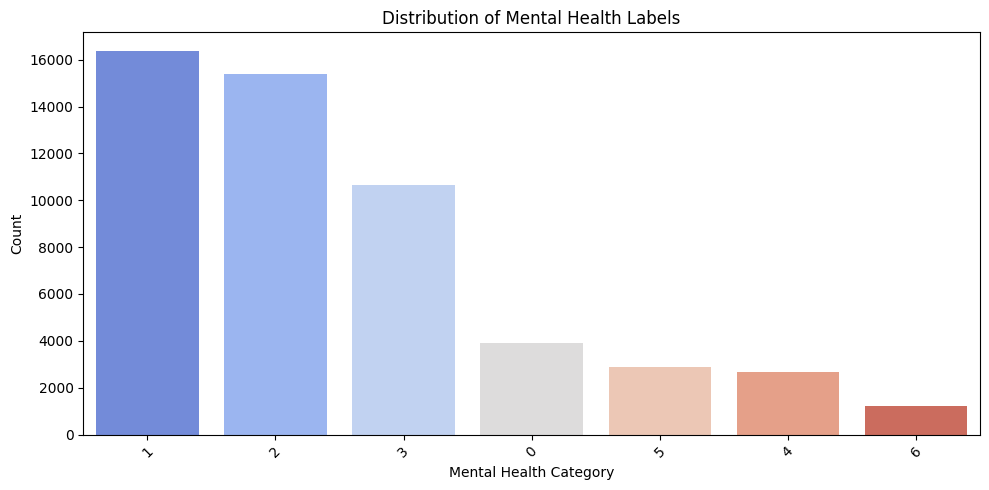

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='status', order=df['status'].value_counts().index, palette='coolwarm')
plt.title('Distribution of Mental Health Labels')
plt.xlabel('Mental Health Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

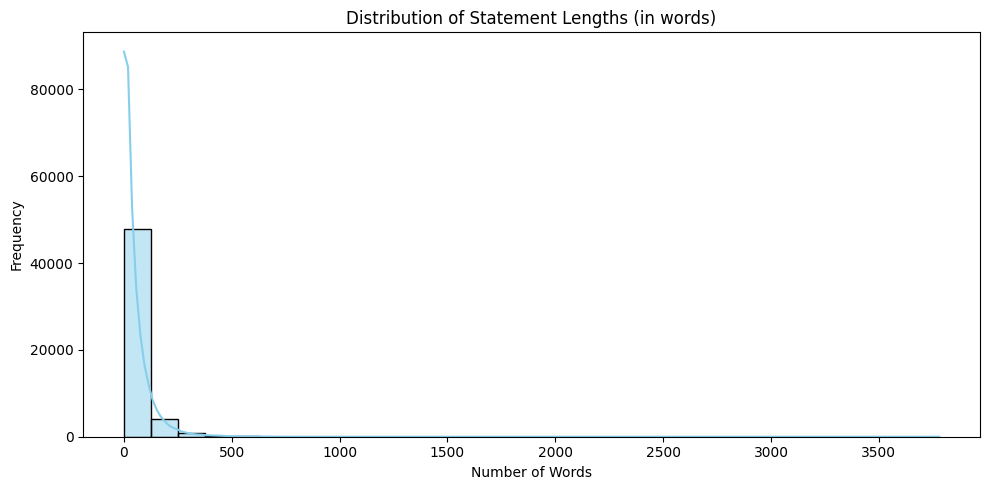

In [ ]:
df['text_length'] = df['statement'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['text_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Statement Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


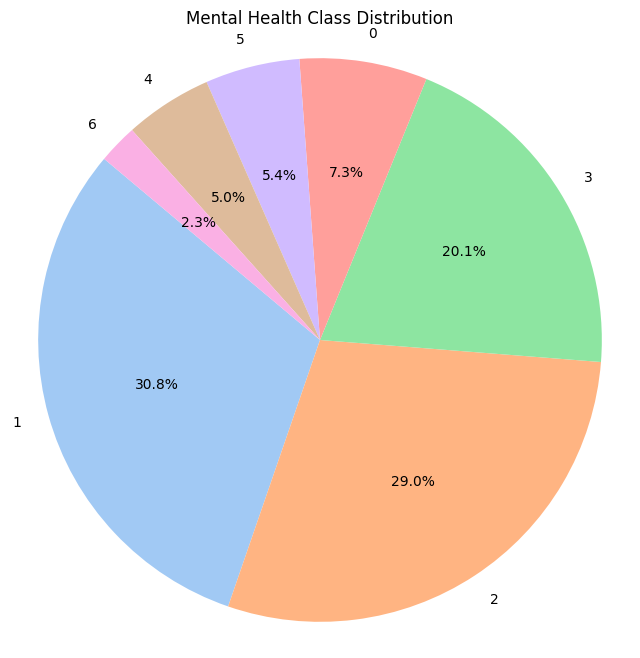

In [ ]:
label_counts = df['status'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Mental Health Class Distribution')
plt.axis('equal')
plt.show()


# **Data Pre-Processing**

Removing Empty Data Elements

In [ ]:
df['statement'] = df['statement'].fillna('')

In [ ]:
df.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [ ]:
df[df["status"] == "Anxiety"]["statement"][1]

'trouble sleeping, confused mind, restless heart. All out of tune'

Creating labels for the Classifier to use

In [ ]:
df["status"].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [ ]:
df["status"] = df["status"].map({'Anxiety':0, 'Normal':1, 'Depression':2, 'Suicidal':3, 'Stress':4, "Bipolar": 5, "Personality disorder": 6})

Running Clear Text Regex on the Dataset

In [ ]:
def clean_text(text):
    text = text.str.lower() # Converts all text to lowercase
    text = text.str.replace(r'[^\w\s]', '', regex = True) # Removes Punctuation and Numbers
    text = text.str.replace("\n" , '', regex = True)
    text = text.str.replace('\d', '', regex = True)
    text = text.str.replace(r'\[.*?\]', '', regex = True)
    text = text.str.replace(r'https?://\S+|www\.\S+', '', regex = True) # Removes Links
    text = text.str.replace(r'<.*?>+', '', regex = True)
    text = text.str.replace(r'\w*\d\w*', '', regex = True)
    return text

In [ ]:
df["statement"] = clean_text(df["statement"])

Removing StopWords from NLTK list

In [1]:
#Removing really common words that could interfere with training
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
    return text

In [ ]:
df["statement"] = remove_stopwords(df["statement"])

Removes 1000 least frequent lines in the dataset

In [ ]:
delete = pd.Series(' '.join(df['statement']).split()).value_counts()[-1000:]
df['statement'] = df['statement'].apply(lambda x: " ".join(x for x in x.split() if x not in delete))

In [ ]:
df = df[['statement', 'status']]
df = df.rename(columns={'status': 'labels'})
dataset = Dataset.from_pandas(df)

Final Pre-Tokenization Output

In [ ]:
print(df['labels'].value_counts())

labels
1    16351
2    15404
3    10653
0     3888
5     2877
4     2669
6     1201
Name: count, dtype: int64


# **Tokenization**

In [ ]:
# 🔠 Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

encodings = tokenizer(df['statement'].tolist(),
                      padding=True,
                      truncation=True,
                      return_tensors='pt')

def tokenize(example):
    tokens = tokenizer(example['statement'], padding='max_length', truncation=True, max_length=128)
    tokens['labels'] = example['labels']
    return tokens

dataset = dataset.map(tokenize, batched = True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/53043 [00:00<?, ? examples/s]

# **Training**

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=7)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

os.environ["WANDB_DISABLED"] = "true"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=50,
    logging_dir='./logs',
    logging_steps=10,
    fp16=True if torch.cuda.is_available() else False,

)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# 🚀 Train the model
trainer.train()

Step,Training Loss
10,1.741100
20,1.443900
30,1.137700
40,1.163900
50,1.036700
60,1.052500
70,0.933300
80,0.893700
90,0.867400
100,0.958000


TrainOutput(global_step=3183, training_loss=0.47402124947210245, metrics={'train_runtime': 501.0541, 'train_samples_per_second': 317.588, 'train_steps_per_second': 6.353, 'total_flos': 5270321071754496.0, 'train_loss': 0.47402124947210245, 'epoch': 3.0})

#**Evaluation**

In [ ]:
preds = trainer.predict(dataset)
y_true = dataset['labels']
y_pred = preds.predictions.argmax(axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3888
           1       0.96      0.99      0.98     16351
           2       0.89      0.86      0.87     15404
           3       0.82      0.86      0.84     10653
           4       0.93      0.87      0.90      2669
           5       0.96      0.91      0.93      2877
           6       0.93      0.82      0.87      1201

    accuracy                           0.91     53043
   macro avg       0.92      0.89      0.91     53043
weighted avg       0.91      0.91      0.91     53043



Overall the model does very well, on second run it performed a lot better than it did the other time in Personality Disorder however this is an inconsitent result

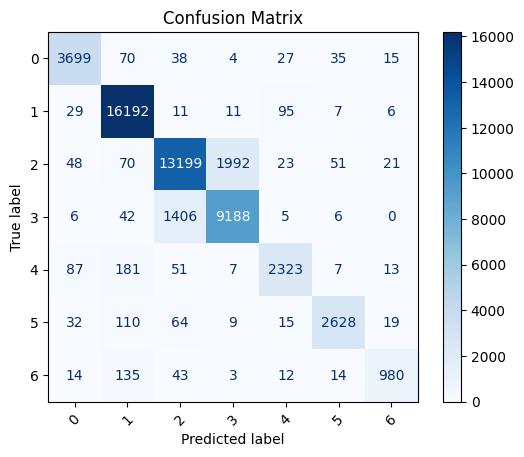

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df["labels"].unique())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


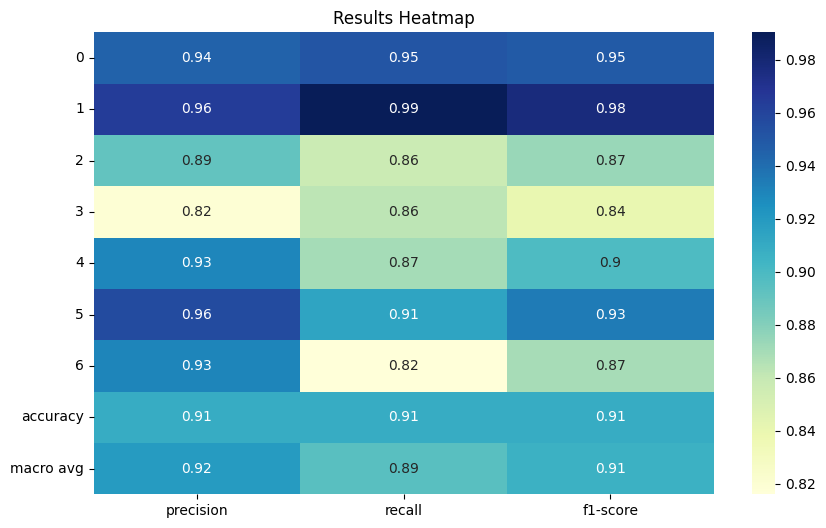

In [ ]:
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(10,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title('Results Heatmap')
plt.show()
